In [ ]:
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data_folder = "data/"

train = pl.read_parquet(data_folder + "train.pq")
test_exploded = pl.read_parquet(data_folder + "test.pq")
books = pl.read_parquet(data_folder + "books.pq")
test = test_exploded.group_by("user_id", maintain_order=True).agg(pl.col("item_id"))

In [36]:
all_items = set(books["item_id"].to_list())
train_items = set(train["item_id"].to_list())
test_items = set(test_exploded["item_id"].to_list())
cold_items = test_items - train_items

print(f"Книг в обучающей выборке: {len(train_items)}")
print(f"Книг в тестовой выборке: {len(test_items)}")
print(f"Холодных книг в тестовой выборке: {len(cold_items)}")
print(f"Процент холодных книг в тестовой выборке: {len(cold_items) / len(test_items) * 100:.2f}%")

Книг в обучающей выборке: 31300
Книг в тестовой выборке: 27365
Холодных книг в тестовой выборке: 1778
Процент холодных книг в тестовой выборке: 6.50%


In [37]:
print(f"Пользователей в обучающей выборке: {train['user_id'].n_unique()}")
print(f"Взаимодействий в обучающей выборке: {train.shape[0]}")
print(f"Пользователей в тестовой выборке: {test['user_id'].n_unique()}")
print(f"Взаимодействий в тестовой выборке: {test_exploded.shape[0]}")
print(f"Книг в каталоге: {books.shape[0]}")

Пользователей в обучающей выборке: 349714
Взаимодействий в обучающей выборке: 11971263
Пользователей в тестовой выборке: 185843
Взаимодействий в тестовой выборке: 3134534
Книг в каталоге: 34330


In [6]:
test_interactions_warm = test_exploded.filter(pl.col('item_id').is_in(list(test_items - cold_items)))
test_interactions_cold = test_exploded.filter(pl.col('item_id').is_in(list(cold_items)))
print(f"Взаимодействий с теплыми книгами в тестовой выборке: {test_interactions_warm.shape[0]}")
print(f"Взаимодействий с холодными книгами в тестовой выборке: {test_interactions_cold.shape[0]}")
print(f"Процент взаимодействий с холодными книгами: {test_interactions_cold.shape[0] / test_exploded.shape[0] * 100:.2f}%")

Взаимодействий с теплыми книгами в тестовой выборке: 2947110
Взаимодействий с холодными книгами в тестовой выборке: 187424
Процент взаимодействий с холодными книгами: 5.98%


In [7]:
print("Рейтинги в обучающей выборке:", set(train["rating"].to_list()))

Рейтинги в обучающей выборке: {0, 1, 2, 3, 4, 5}


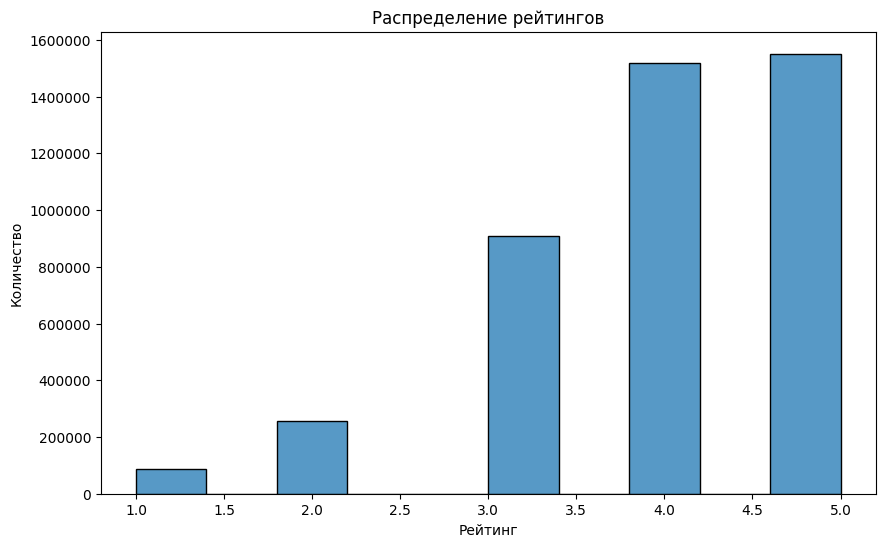

In [8]:
plt.figure(figsize=(10, 6))
plt.ticklabel_format(style='plain', axis='y')
train_ratings = train.filter(pl.col("rating") > 0)["rating"].to_list()
sns.histplot(train_ratings, bins=10)
plt.title('Распределение рейтингов')
plt.xlabel('Рейтинг')
plt.ylabel('Количество')
plt.show()

В основном присутствуют рейтинги 4-5

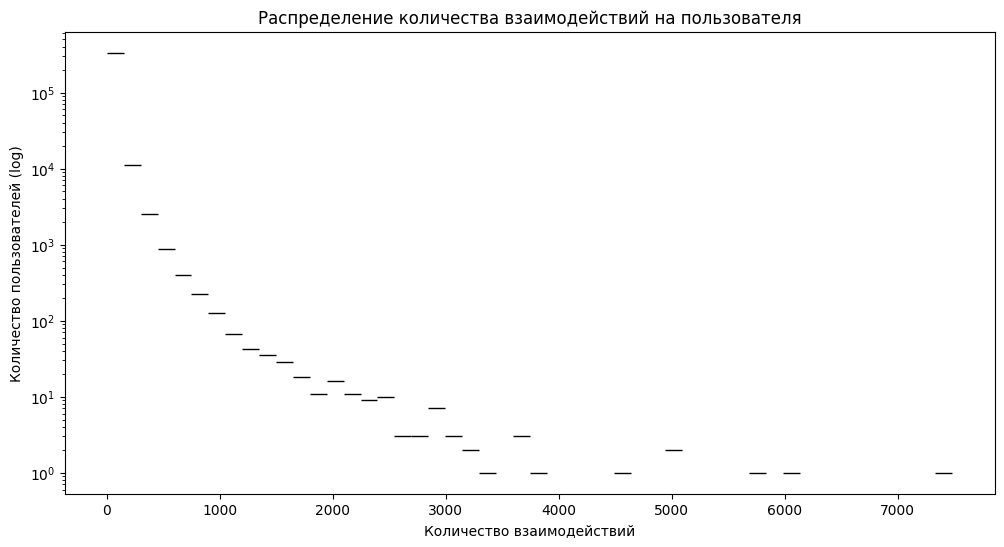

In [9]:
user_interactions = train.group_by("user_id").agg(
    n_interactions=pl.len(),
    n_rated=pl.col("rating").filter(pl.col("rating") > 0).count(),
    n_read=pl.col("is_read").sum(),
    avg_rating=pl.col("rating").filter(pl.col("rating") > 0).mean()
)

plt.figure(figsize=(12, 6))
sns.histplot(user_interactions["n_interactions"].to_list(), bins=50, log_scale=(False, True))
plt.title('Распределение количества взаимодействий на пользователя')
plt.xlabel('Количество взаимодействий')
plt.ylabel('Количество пользователей (log)')
plt.show()

Большинство пользователей неактивны, они совершают очень мало действий, распределение резко убывает

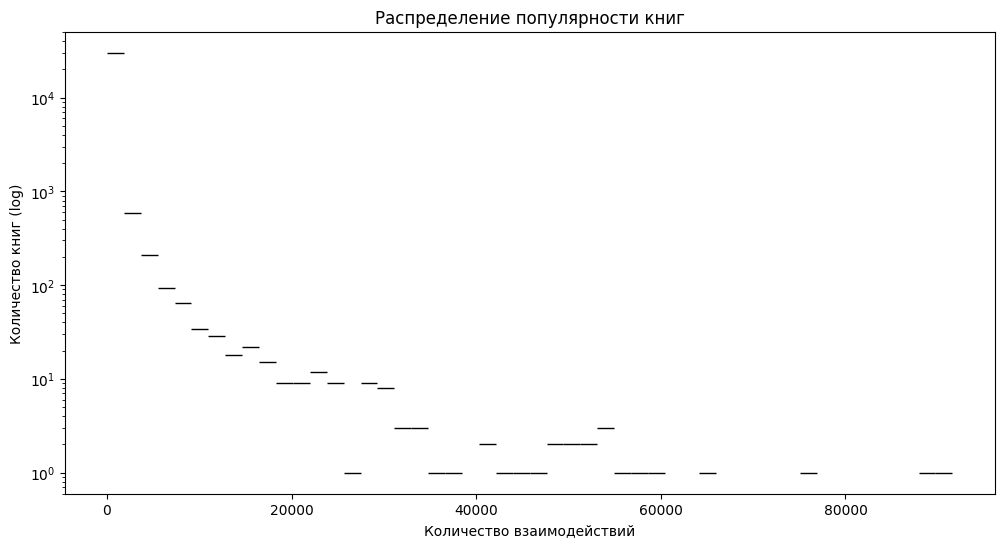

In [10]:
item_popularity = train.group_by("item_id").agg(
    n_interactions=pl.len(),
    n_rated=pl.col("rating").filter(pl.col("rating") > 0).count(),
    n_read=pl.col("is_read").sum(),
    avg_rating=pl.col("rating").filter(pl.col("rating") > 0).mean()
)

plt.figure(figsize=(12, 6))
sns.histplot(item_popularity["n_interactions"].to_list(), bins=50, log_scale=(False, True))
plt.title('Распределение популярности книг')
plt.xlabel('Количество взаимодействий')
plt.ylabel('Количество книг (log)')
plt.show()

Большинство книг почти не получают взаимодействий, есть небольшой пул хитов (длинный хвост)

Процент холодных книг с описанием: 92.35%
Процент теплых книг с описанием: 95.55%
Среднее количество тегов для холодных книг: 63.31
Среднее количество тегов для теплых книг: 82.21


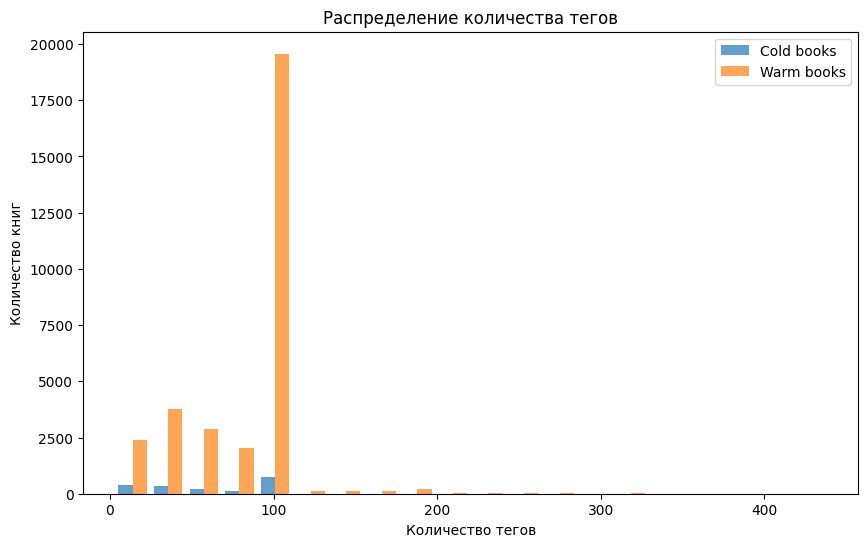

In [11]:
cold_books = books.filter(pl.col("item_id").is_in(list(cold_items)))
warm_books = books.filter(pl.col("item_id").is_in(list(train_items)))

cold_with_desc = cold_books.filter(pl.col('description').str.len_chars() > 0).shape[0]
warm_with_desc = warm_books.filter(pl.col('description').str.len_chars() > 0).shape[0]
print(f"Процент холодных книг с описанием: {cold_with_desc / cold_books.shape[0] * 100:.2f}%")
print(f"Процент теплых книг с описанием: {warm_with_desc / warm_books.shape[0] * 100:.2f}%")

cold_tags_count = cold_books["tags"].list.len()
warm_tags_count = warm_books["tags"].list.len()
print(f"Среднее количество тегов для холодных книг: {cold_tags_count.mean():.2f}")
print(f"Среднее количество тегов для теплых книг: {warm_tags_count.mean():.2f}")

plt.figure(figsize=(10, 6))
plt.hist([cold_tags_count.to_list(), warm_tags_count.to_list()], 
         bins=20, alpha=0.7, label=['Cold books', 'Warm books'])
plt.title('Распределение количества тегов')
plt.xlabel('Количество тегов')
plt.ylabel('Количество книг')
plt.legend()
plt.show()

Для тёплых книг гистограмма смещена вправо, есть пик около 100 тегов, затем длинный хвост до 300+. Для холодных книг теги чаще встречаются в меньшем количестве (20-100)

В целом тёплые книги описаны богаче (больше тегов), чем холодные

In [12]:
cold_authors_count = cold_books["authors"].list.len()
warm_authors_count = warm_books["authors"].list.len()
print(f"Среднее количество авторов для холодных книг: {cold_authors_count.mean():.2f}")
print(f"Среднее количество авторов для теплых книг: {warm_authors_count.mean():.2f}")

Среднее количество авторов для холодных книг: 1.22
Среднее количество авторов для теплых книг: 1.32


In [13]:
cold_series_count = cold_books.filter(pl.col("series").is_not_null())["series"].list.len()
warm_series_count = warm_books.filter(pl.col("series").is_not_null())["series"].list.len()
print(f"Процент холодных книг в серии: {cold_books.filter(pl.col('series').list.len() > 0).shape[0] / cold_books.shape[0] * 100:.2f}%")
print(f"Процент теплых книг в серии: {warm_books.filter(pl.col('series').list.len() > 0).shape[0] / warm_books.shape[0] * 100:.2f}%")

Процент холодных книг в серии: 100.00%
Процент теплых книг в серии: 100.00%


In [14]:
all_tags = []
for tags_list in books["tags"].to_list():
    all_tags.extend(tags_list)

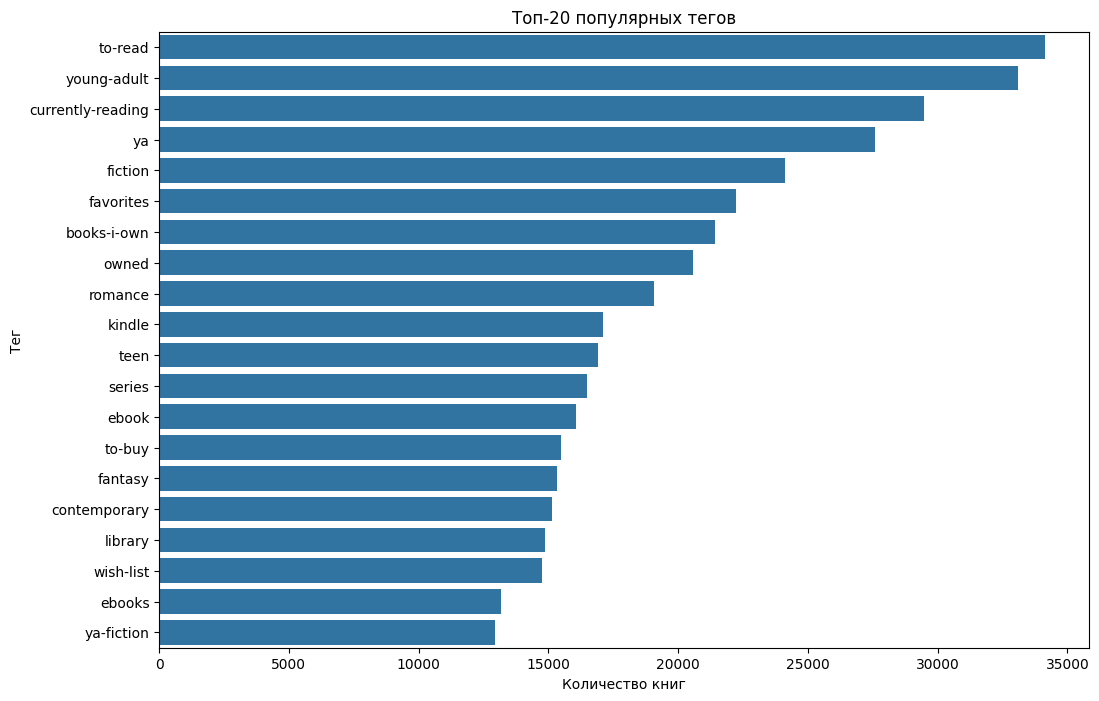

In [15]:
from collections import Counter

tag_counts = Counter(all_tags)
top_tags = pd.DataFrame(tag_counts.most_common(20), columns=['tag', 'count'])

plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='tag', data=top_tags)
plt.title('Топ-20 популярных тегов')
plt.xlabel('Количество книг')
plt.ylabel('Тег')
plt.show()

Лидируют теги to‑read, currently‑reading, owned. Высокие значения у young‑adult, ya, fiction.
Дальше идут жанровые (romance, fantasy, teen) и платформенные (kindle, ebook/ebooks, library)

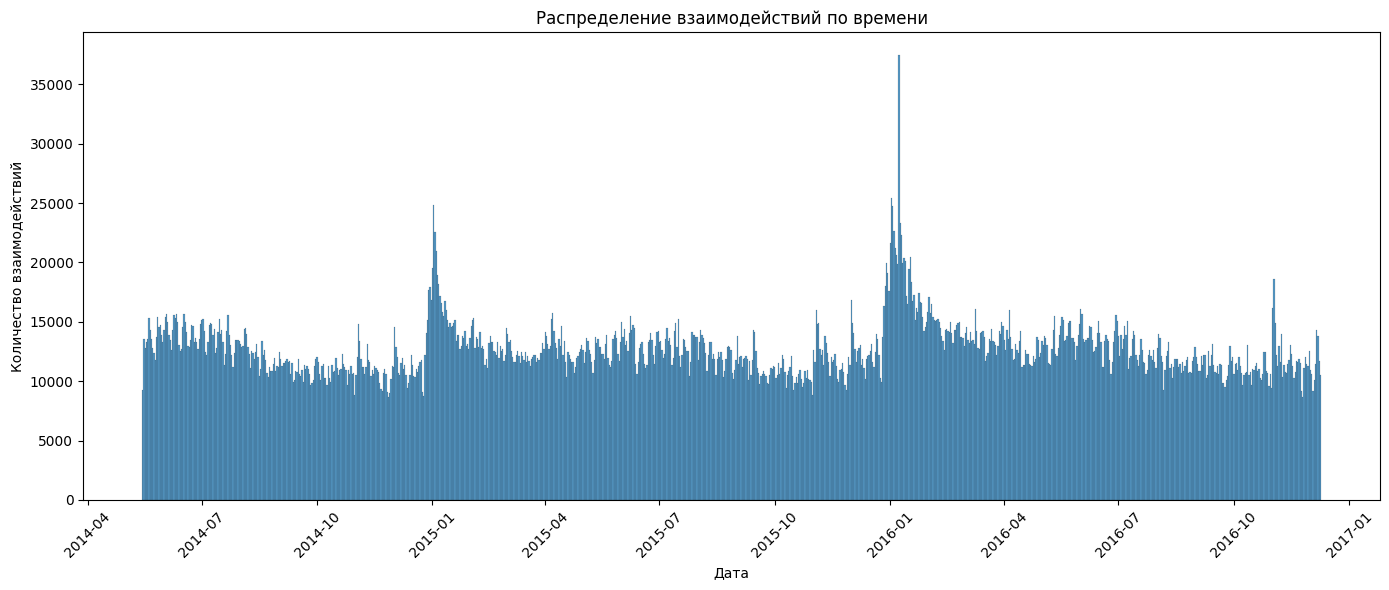

In [16]:
train_dates = train["date_added"].dt.date().to_list()
plt.figure(figsize=(14, 6))
sns.histplot(train_dates, bins=50)
plt.title('Распределение взаимодействий по времени')
plt.xlabel('Дата')
plt.ylabel('Количество взаимодействий')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

В основном столбцы на уровне 10–14 тыс., но есть сезонные колебания. Также есть 2 пика: конец 2014/начало 2015 и начало 2016 (пик  около 37 тыс.). После пиков значения возвращаются к базовому уровню

## Предобработка данных

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from tqdm.notebook import tqdm
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [18]:
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    if not text or pd.isna(text):
        return ""
    
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    text = ' '.join(words)
    
    return text

Предобработка метаданных книг:

In [20]:
books_preprocessed = books.with_columns([
    pl.col("title").map_elements(preprocess_text, return_dtype=pl.Utf8).alias("title_processed"),
    pl.col("description").map_elements(preprocess_text, return_dtype=pl.Utf8).alias("description_processed"),
])

books_preprocessed = books_preprocessed.with_columns([
    pl.col("tags").list.join(" ").map_elements(preprocess_text, return_dtype=pl.Utf8).alias("tags_processed")
])

books_preprocessed = books_preprocessed.with_columns([ # объединили все текстовые признаки
    pl.concat_str([
        pl.col("title_processed"),
        pl.col("description_processed"),
        pl.col("tags_processed")
    ], separator=" ").alias("text_features")
])

Создание TF-IDF признаков для книг:

In [21]:
vectorizer = TfidfVectorizer(
    max_features=1000,
    min_df=5,
    max_df=0.8,
    stop_words='english'
)

tfidf_matrix = vectorizer.fit_transform(books_preprocessed["text_features"].to_list())
tfidf_matrix_normalized = normalize(tfidf_matrix)
tfidf_features = tfidf_matrix_normalized.toarray().tolist()

books_preprocessed = books_preprocessed.with_columns([
    pl.Series("tfidf_features", tfidf_features)
])

Создание признаков на основе авторов и серий:

In [22]:
all_authors = set()
for authors_list in books["authors"].to_list():
    for author_info in authors_list:
        if isinstance(author_info, dict) and 'name' in author_info:
            all_authors.add(author_info['name'])
        elif isinstance(author_info, str):
            all_authors.add(author_info)

author_to_idx = {author: idx for idx, author in enumerate(all_authors)}

def create_author_features(authors_list):
    if not authors_list:
        return []
    
    features = np.zeros(len(author_to_idx))
    for author_info in authors_list:
        if isinstance(author_info, dict) and 'name' in author_info:
            author_name = author_info['name']
        elif isinstance(author_info, str):
            author_name = author_info
        else:
            continue
            
        if author_name in author_to_idx:
            features[author_to_idx[author_name]] = 1
    
    return features.tolist()

author_features = [create_author_features(authors) for authors in books["authors"].to_list()]
books_preprocessed = books_preprocessed.with_columns([
    pl.Series("author_features", author_features)
])

Создание разреженной матрицы:

In [ ]:
from scipy.sparse import csr_matrix

user_ids = train["user_id"].unique().to_list()
user_to_idx = {user_id: idx for idx, user_id in enumerate(user_ids)}

item_ids = books["item_id"].to_list()
item_to_idx = {item_id: idx for idx, item_id in enumerate(item_ids)}

rows, cols, data = [], [], []

for row in tqdm(train.iter_rows(named=True)):
    user_idx = user_to_idx.get(row["user_id"])
    item_idx = item_to_idx.get(row["item_id"])
    
    if user_idx is None or item_idx is None:
        continue
    
    weight = row["rating"] if row["rating"] > 0 else 1
    
    rows.append(user_idx)
    cols.append(item_idx)
    data.append(weight)

interaction_matrix = csr_matrix((data, (rows, cols)), shape=(len(user_ids), len(item_ids)))


0it [00:00, ?it/s]

Разделение на обучающую и валидационную выборки:

In [24]:
warm_items = train_items

In [38]:
train = train.with_columns(
    pl.coalesce([
        pl.col("date_added").cast(pl.Datetime, strict=False),
        pl.col("date_added").cast(pl.Utf8).str.strptime(pl.Datetime, strict=False, exact=False),
    ]).alias("date_added")
).drop_nulls(["date_added"])

print("dtype:", train.schema["date_added"])
print("nulls:", train["date_added"].is_null().sum(), "rows:", train.height)

dtype: Datetime(time_unit='us', time_zone=None)
nulls: 0 rows: 11971263


In [46]:
train_items = set(train["item_id"].to_list())
test_items  = set(test_exploded["item_id"].to_list())

test_cold_items = test_items - train_items

test_cold_interactions = test_exploded.filter(pl.col("item_id").is_in(list(test_cold_items)))
cold_interactions_share_test = test_cold_interactions.shape[0] / max(1, test_exploded.shape[0])

print(f"Доля холодных взаимодействий в тесте: {cold_interactions_share_test:.3f}")

Доля холодных взаимодействий в тесте: 0.060


In [41]:
df_sorted = train.sort("date_added")
n = df_sorted.height

quantile = 0.74
idx = int(np.clip(round(n * quantile), 1, n - 1))

train_part = df_sorted.slice(0, idx)
val_part_raw = df_sorted.slice(idx, n - idx)

warm_users = set(train_part["user_id"].unique().to_list()) # вал только по тёплым пользователям (как в тесте)
val_part = (
    val_part_raw
    .filter(pl.col("user_id").is_in(list(warm_users)))
    .sort("user_id", "rating", "is_read", descending=True)
)

val_ground_truth = val_part.group_by("user_id", maintain_order=True).agg(pl.col("item_id"))
train_items = set(train_part["item_id"].to_list())
val_items = set(val_part["item_id"].to_list())
val_cold_items = val_items - train_items

den = train_part.shape[0] + val_part.shape[0]
val_share = val_part.shape[0] / den if den > 0 else 0.0
cold_interactions_share = (
    val_part.filter(pl.col("item_id").is_in(list(val_cold_items))).shape[0] / max(1, val_part.shape[0])
)

print(f"Вал доля взаимодействий: {val_share:.3f}")
print(f"Доля холодных взаимодействий в валидации: {cold_interactions_share:.3f}")
print(f"Пользователей train_part: {train_part['user_id'].n_unique()}, в val_part: {val_part['user_id'].n_unique()}")

Вал доля взаимодействий: 0.212
Доля холодных взаимодействий в валидации: 0.050
Пользователей train_part: 309834, в val_part: 161758


Получилось близко к тесту (0.21 (из файла data_splitting.ipynb) и 0.06)

Все вал пользователи должны быть тёплыми:

In [40]:

assert len(set(val_ground_truth["user_id"].to_list()) - set(train_part["user_id"].unique().to_list())) == 0

In [ ]:
user_features = train_part.group_by("user_id").agg([
    pl.len().alias("n_interactions"),
    pl.n_unique("item_id").alias("n_items"),
    pl.col("rating").mean().alias("mean_rating"),
])

users = train_part["user_id"].unique().to_list()
items = train_part["item_id"].unique().to_list()
user_to_idx = {u: i for i, u in enumerate(users)}
item_to_idx = {it: j for j, it in enumerate(items)}
rows = [user_to_idx[u] for u in train_part["user_id"].to_list()]
cols = [item_to_idx[i] for i in train_part["item_id"].to_list()]
data = np.ones(len(rows), dtype=np.float32)
interaction_matrix = csr_matrix((data, (rows, cols)), shape=(len(users), len(items)))

train_items_set = set(items)
val_items_set = set(val_part["item_id"].unique().to_list())
val_cold_items = val_items_set - train_items_set

In [ ]:
import os, pickle, scipy.sparse
os.makedirs("processed_data", exist_ok=True)

user_features.write_parquet("processed_data/user_features.pq")
train_part.write_parquet("processed_data/train_data.pq")
val_part.write_parquet("processed_data/val_data.pq")
val_ground_truth.write_parquet("processed_data/val_ground_truth.pq")
scipy.sparse.save_npz("processed_data/interaction_matrix.npz", interaction_matrix)
with open("processed_data/user_to_idx.pkl", "wb") as f:
    pickle.dump(user_to_idx, f)
with open("processed_data/item_to_idx.pkl", "wb") as f:
    pickle.dump(item_to_idx, f)
with open("processed_data/cold_items.pkl", "wb") as f:
    pickle.dump(val_cold_items, f)
with open("processed_data/warm_items.pkl", "wb") as f:
    pickle.dump(train_items_set, f)